In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
 
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

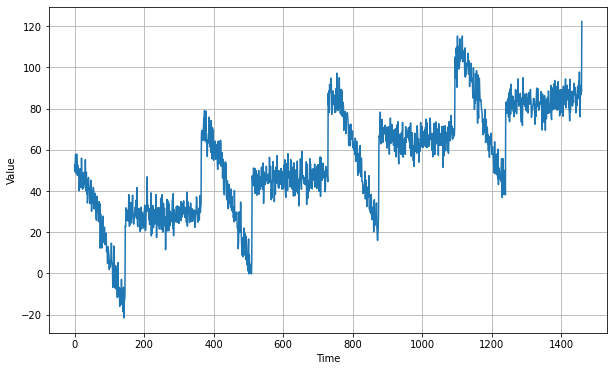

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 2s 17ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - l

31/31 [==============================] - 0s 4ms/step - loss: 5.7668 - mae: 6.2473 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/100
31/31 [==============================] - 0s 4ms/step - loss: 5.7735 - mae: 6.2540 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7196 - mae: 6.1992 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/100
31/31 [==============================] - 0s 4ms/step - loss: 5.7195 - mae: 6.2001 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7116 - mae: 6.1953 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6455 - mae: 6.1273 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/100
31/31 [==============================] - 0s 3ms/step - loss: 5.5995 - mae: 6.0752 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6110 - mae: 6

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

31/31 [==============================] - 0s 1ms/step - loss: 28.8771 - mae: 29.3738
Epoch 88/100
31/31 [==============================] - 0s 1ms/step - loss: 21.0317 - mae: 21.5249
Epoch 89/100
31/31 [==============================] - 0s 1ms/step - loss: 22.6008 - mae: 23.0944
Epoch 90/100
31/31 [==============================] - 0s 1ms/step - loss: 48.1103 - mae: 48.6063
Epoch 91/100
31/31 [==============================] - 0s 1ms/step - loss: 98.3929 - mae: 98.8925
Epoch 92/100
31/31 [==============================] - 0s 1ms/step - loss: 81.0680 - mae: 81.5671
Epoch 93/100
31/31 [==============================] - 0s 1ms/step - loss: 61.0700 - mae: 61.5689
Epoch 94/100
31/31 [==============================] - 0s 1ms/step - loss: 63.0719 - mae: 63.5710
Epoch 95/100
31/31 [==============================] - 0s 1ms/step - loss: 56.7807 - mae: 57.2791
Epoch 96/100
31/31 [==============================] - 0s 1ms/step - loss: 96.2016 - mae: 96.6992
Epoch 97/100
31/31 [=======================

(1e-06, 0.001, 0.0, 20.0)

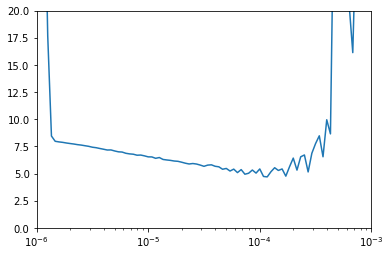

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 5ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - lo

31/31 [==============================] - 0s 3ms/step - loss: 5.7668 - mae: 6.2473 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7735 - mae: 6.2540 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7196 - mae: 6.1992 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7195 - mae: 6.2001 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7116 - mae: 6.1953 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/500
31/31 [==============================] - 0s 3ms/step - loss: 5.6455 - mae: 6.1273 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/500
31/31 [==============================] - 0s 3ms/step - loss: 5.5995 - mae: 6.0752 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/500
31/31 [==============================] - 0s 3ms/step - loss: 5.6110 - mae: 6

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7014 - mae: 5.1780 - val_loss: 5.0025 - val_mae: 5.4797
Epoch 126/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6727 - mae: 5.1444 - val_loss: 4.9720 - val_mae: 5.4553
Epoch 127/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6785 - mae: 5.1538 - val_loss: 4.9888 - val_mae: 5.4690
Epoch 128/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6817 - mae: 5.1575 - val_loss: 4.8904 - val_mae: 5.3673
Epoch 129/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6582 - mae: 5.1312 - val_loss: 4.9069 - val_mae: 5.3925
Epoch 130/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6306 - mae: 5.0997 - val_loss: 4.9076 - val_mae: 5.3829
Epoch 131/500
31/31 [==============================] - 0s 7ms/step - loss: 4.7226 - mae: 5.1940 - val_loss: 4.9074 - val_mae: 5.3918
Epoch 132/500
31/31 [==============================] - 0s 6ms/step - 

31/31 [==============================] - 0s 3ms/step - loss: 4.4405 - mae: 4.9176 - val_loss: 4.9912 - val_mae: 5.4687
Epoch 187/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3811 - mae: 4.8573 - val_loss: 4.8905 - val_mae: 5.3692
Epoch 188/500
31/31 [==============================] - 0s 3ms/step - loss: 4.4497 - mae: 4.9265 - val_loss: 4.5827 - val_mae: 5.0545
Epoch 189/500
31/31 [==============================] - 0s 3ms/step - loss: 4.5007 - mae: 4.9756 - val_loss: 4.7732 - val_mae: 5.2578
Epoch 190/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3986 - mae: 4.8711 - val_loss: 4.8453 - val_mae: 5.3263
Epoch 191/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3835 - mae: 4.8578 - val_loss: 4.6002 - val_mae: 5.0768
Epoch 192/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3800 - mae: 4.8554 - val_loss: 4.7555 - val_mae: 5.2396
Epoch 193/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3818 -

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [15]:
lin_forecast.shape

(461,)

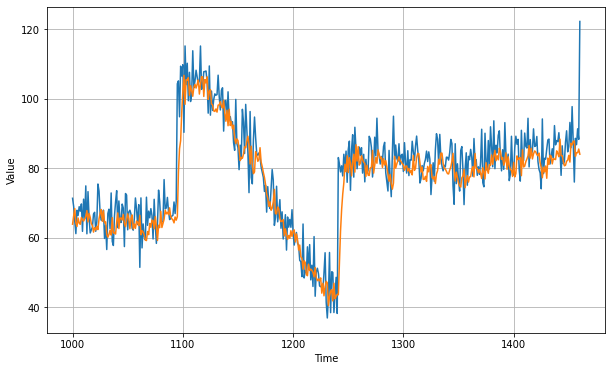

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662664

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 43.8270 - mae: 44.3262
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 41.5210 - mae: 42.0202
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 38.6253 - mae: 39.1248
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 35.3203 - mae: 35.8201
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 31.5905 - mae: 32.0903
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 27.4033 - mae: 27.9022
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 22.7830 - mae: 23.2804
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 17.7632 - mae: 18.2594
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 12.6771 - mae: 13.1682
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 8.5974 - mae: 9.0856
Epoch 11/100
31/31 [=====================

31/31 [==============================] - 0s 1ms/step - loss: 36.2514 - mae: 36.7487
Epoch 88/100
31/31 [==============================] - 0s 1ms/step - loss: 40.0997 - mae: 40.5979
Epoch 89/100
31/31 [==============================] - 0s 1ms/step - loss: 41.1148 - mae: 41.6135
Epoch 90/100
31/31 [==============================] - 0s 1ms/step - loss: 40.1843 - mae: 40.6828
Epoch 91/100
31/31 [==============================] - 0s 2ms/step - loss: 39.3844 - mae: 39.8820
Epoch 92/100
31/31 [==============================] - 0s 1ms/step - loss: 38.4802 - mae: 38.9782
Epoch 93/100
31/31 [==============================] - 0s 1ms/step - loss: 37.5065 - mae: 38.0044
Epoch 94/100
31/31 [==============================] - 0s 1ms/step - loss: 36.3971 - mae: 36.8952
Epoch 95/100
31/31 [==============================] - 0s 1ms/step - loss: 35.1905 - mae: 35.6887
Epoch 96/100
31/31 [==============================] - 0s 1ms/step - loss: 33.8342 - mae: 34.3320
Epoch 97/100
31/31 [=======================

(1e-07, 0.005, 0.0, 30.0)

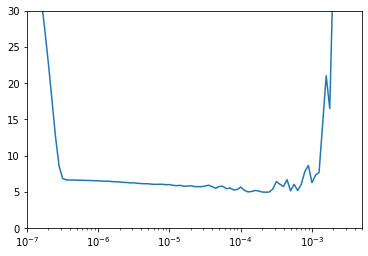

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 6ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - loss: 6.9028 

31/31 [==============================] - 0s 3ms/step - loss: 5.1874 - mae: 5.6697 - val_loss: 5.0692 - val_mae: 5.5508
Epoch 64/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1751 - mae: 5.6555 - val_loss: 5.2834 - val_mae: 5.7662
Epoch 65/500
31/31 [==============================] - 0s 3ms/step - loss: 5.2088 - mae: 5.6886 - val_loss: 5.0484 - val_mae: 5.5301
Epoch 66/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1744 - mae: 5.6535 - val_loss: 5.1831 - val_mae: 5.6589
Epoch 67/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1534 - mae: 5.6338 - val_loss: 5.0369 - val_mae: 5.5184
Epoch 68/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1575 - mae: 5.6382 - val_loss: 5.0227 - val_mae: 5.5027
Epoch 69/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1541 - mae: 5.6362 - val_loss: 5.1051 - val_mae: 5.5804
Epoch 70/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1305 - mae: 5

Epoch 125/500
31/31 [==============================] - 0s 3ms/step - loss: 4.7814 - mae: 5.2602 - val_loss: 4.7709 - val_mae: 5.2495
Epoch 126/500
31/31 [==============================] - 0s 3ms/step - loss: 4.7547 - mae: 5.2327 - val_loss: 4.7648 - val_mae: 5.2428
Epoch 127/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7337 - mae: 5.2090 - val_loss: 4.8925 - val_mae: 5.3660
Epoch 128/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7231 - mae: 5.2004 - val_loss: 4.7861 - val_mae: 5.2643
Epoch 129/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7312 - mae: 5.2095 - val_loss: 4.7655 - val_mae: 5.2437
Epoch 130/500
31/31 [==============================] - 0s 4ms/step - loss: 4.7267 - mae: 5.2040 - val_loss: 4.7819 - val_mae: 5.2601
Epoch 131/500
31/31 [==============================] - 0s 3ms/step - loss: 4.8444 - mae: 5.3232 - val_loss: 4.9965 - val_mae: 5.4721
Epoch 132/500
31/31 [==============================] - 0s 4ms/step - 

In [21]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

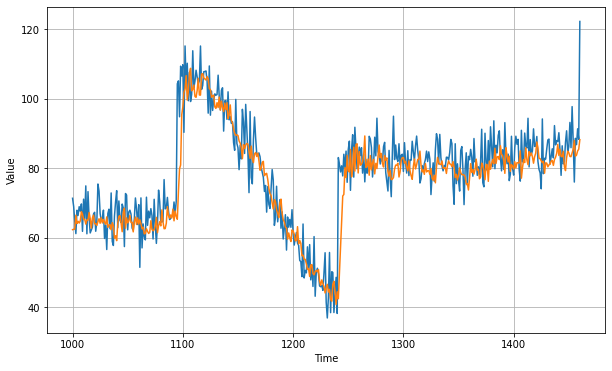

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.202555